In [1]:
#import sys
#sys.path.insert(0,"/workspace/bt")

import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import bt

%matplotlib inline

In [2]:
print('bt version : ', bt.__version__)

bt version :  (0, 2, 9)


In [3]:
tickers = ['TQQQ','TMF']
dualtickers = ['BND','PQTIX']
#start='2022-11-01'

In [4]:
data = yf.download(tickers+dualtickers)['Adj Close']
data = data[tickers+dualtickers]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()   
start_day = assets.index.min()
print('asset \n', assets.head(30))

[*********************100%***********************]  4 of 4 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BND 2007-04-10 00:00:00
PQTIX 2014-01-06 00:00:00
asset 
                 TQQQ        TMF        BND     PQTIX
Date                                                
2014-01-06  2.437851  10.264057  63.538197  7.285855
2014-01-07  2.501026  10.351744  63.617470  7.285855
2014-01-08  2.519730  10.275593  63.411465  7.278570
2014-01-09  2.493753  10.437125  63.530285  7.285855
2014-01-10  2.518691  10.810948  63.839283  7.285855
2014-01-13  2.406679  10.981710  63.926418  7.278570
2014-01-14  2.544459  10.824793  63.831314  7.285855
2014-01-15  2.603894  10.806334  63.791759  7.293142
2014-01-16  2.609296  10.995554  63.934334  7.307713
2014-01-17  2.562955  11.136317  64.005630  7.322284
2014-01-21  2.620311  11.161697  64.005630  7.329571
2014-01-22  2.644625  11.092471  63.894726  7.329571
2014-01-23  2.612830  11.565523  64.069069  7.322284
2014-01-24  2.458009  11.7662

In [15]:
#상대모멘텀 종목 선정
class SelectRelativeMomentum(bt.Algo):
    def __init__(self, rank, lookback=pd.DateOffset(months=1), lag=pd.DateOffset(days=1)):
        super(SelectRelativeMomentum, self).__init__()
        self.rank = rank
        self.lookback = lookback
        self.lag = lag
        
    def __call__(self, target):
        assets = target.universe.columns
        end = target.now - self.lag
        start = end - self.lookback
        prc = target.universe.loc[start:end, assets]
        momentum = prc.calc_total_return()
        rank = momentum.rank(ascending=False)
        #print('rank \n', rank)
        
        selected = pd.Series(dtype=object)
        for i in range(0, len(momentum)):
            if (rank[assets[i]] <= self.rank):
                selected = pd.concat([selected, pd.Series([assets[i]],index=[assets[i]],dtype=object)])
                
        target.temp['selected'] = selected         
        return True

In [6]:
#절대모멘텀 종목 선정
class SelectAbsoluteMomentum(bt.Algo):
    def __init__(self, rank, lookback=pd.DateOffset(months=1), lag=pd.DateOffset(days=1)):
        super(SelectAbsoluteMomentum, self).__init__()
        self.rank = rank
        self.lookback = lookback
        self.lag = lag
        
    def __call__(self, target):
        assets = target.universe.columns
        end = target.now - self.lag
        start = end - self.lookback
        prc = target.universe.loc[start:end, assets]
        momentum = prc.calc_total_return()
        rank = momentum.rank(ascending=False)
        #print('rank \n', rank)
        
        selected = pd.Series(dtype=object)
        for i in range(0, len(momentum)):
            if (rank[assets[i]] <= self.rank) & (momentum[i] > 0):
                selected = pd.concat([selected, pd.Series([assets[i]],index=[assets[i]],dtype=object)])
                
        target.temp['selected'] = selected         
        return True

In [7]:
# 듀얼모멘텀 종목 선정
class SelectDualMomentum(bt.Algo):
    def __init__(self, rank=1, lookback=pd.DateOffset(months=1), lag=pd.DateOffset(days=1)):
        super(SelectDualMomentum, self).__init__()
        self.rank = rank
        self.lookback = lookback
        self.lag = lag
    
    def __call__(self, target):
        assets = target.universe.columns
        #assets = target.temp['selected'].copy()
        #print('assets \n', assets)
        end = target.now - self.lag
        start = end - self.lookback
        #print('start={}, end={}'.format(start, end))
        prc = target.universe.loc[start:end][assets[0:len(assets)-1]]
        momentum = prc.calc_total_return()
        #print('momentum \n', momentum)
        rank = momentum[assets[0:len(assets)-2]].rank(ascending=False)
        #print('rank \n', rank)
        
        selected = pd.Series(dtype=object)
        for i in range(0, len(assets)-2):
            #print('rank[{}]={}, self.n={}, momentum[{}]={}, momentum[{}]={}'.format(assets[i],rank[assets[i]],self.rank,assets[i], momentum[assets[i]],assets[-2],momentum[-1]))
            if rank[assets[i]] <= self.rank:
                if momentum[assets[i]] > momentum[-1]:
                    selected = pd.concat([selected, pd.Series([assets[i]],index=[assets[i]],dtype=object)])
                else:
                    selected = pd.concat([selected, pd.Series([assets[-1]],index=[assets[-1]],dtype=object)])

        target.temp['selected'] = selected
        #print('selected \n', selected)
        return True

In [13]:
# 상대모멘텀 백테스트
def RelativeMomentum_BT(assets, rank, months, start_day, name='Relative Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           #bt.algos.SelectAll(),
                           SelectRelativeMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=1)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [9]:
# 절대모멘텀 백테스트
def AbsoluteMomentum_BT(assets, rank, months, start_day, name='Absolute Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           #bt.algos.SelectAll(),
                           SelectAbsoluteMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=1)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [27]:
# 듀얼모멘텀 백테스트
def DualMomentum_BT(assets, rank, months, start_day, name='Dual Momentum'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=True, run_on_last_date=False),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),
                           #bt.algos.PrintDate(),
                           #bt.algos.SelectAll(),
                           SelectDualMomentum(rank=rank, lookback=pd.DateOffset(months=months), lag=pd.DateOffset(days=1)),
                           bt.algos.WeighEqually(),
                           #bt.algos.PrintTempData(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [10]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=100000000.0)

In [11]:
# 벤치마크 수익율
benchmark = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))

In [16]:
# 상대모멘텀 상위 1종목 (1~12개월 비교)
relativemomentum = {}
for i in range(0, 12):
    start_day = assets.index.min() + pd.DateOffset(months=i+1) - pd.DateOffset(days=1)    
    relativemomentum[i] = RelativeMomentum_BT(assets[tickers], 1, i+1, start_day, name='RM({})'.format(str(i+1)))
    
report = bt.run(benchmark, *relativemomentum.values())

<AxesSubplot:title={'center':'Equity Progression'}>

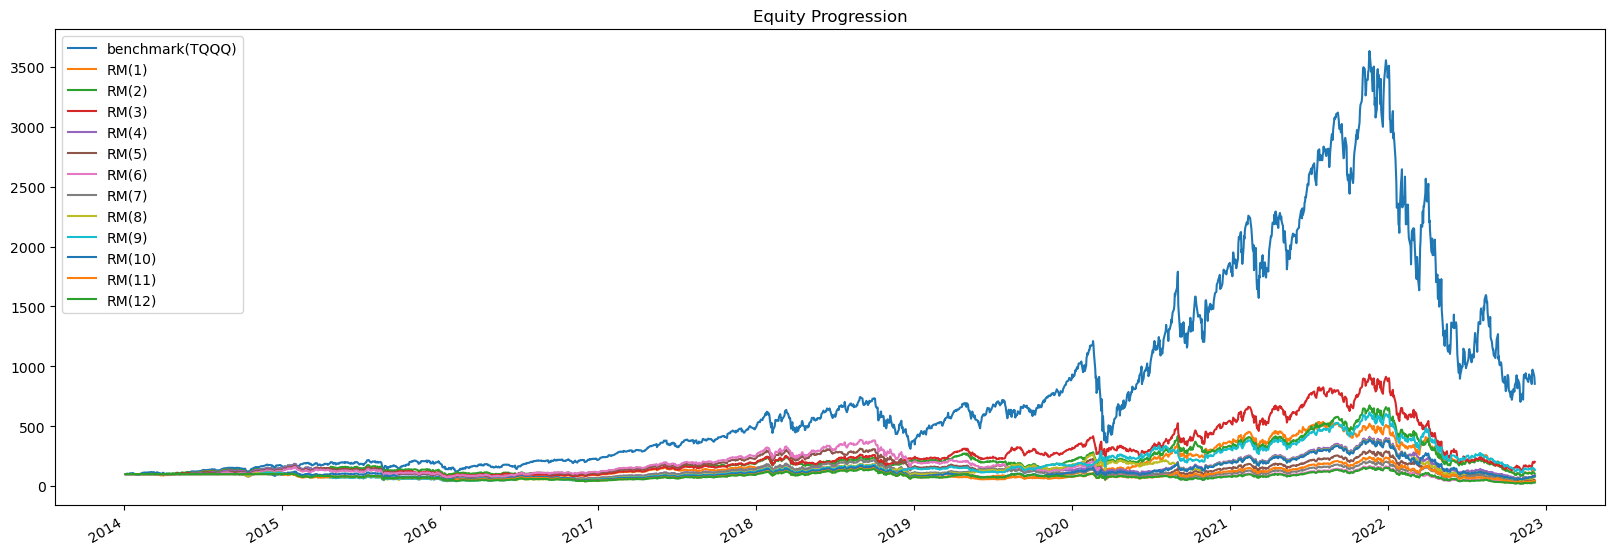

In [17]:
report.plot(figsize=(20,7))

In [18]:
print(report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TQQQ)    RM(1)       RM(2)       RM(3)       RM(4)       RM(5)       RM(6)       RM(7)       RM(8)       RM(9)       RM(10)      RM(11)      RM(12)
-------------------  -----------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05         2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06         2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%              0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         442.54%            -10.55%     -33.57%     39.50%      -41.73%     -65.4

In [19]:
# 절대모멘텀 상위 1종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):
    start_day = assets.index.min() + pd.DateOffset(months=i+1) - pd.DateOffset(days=1)    
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 1, i+1, start_day, name='AM({})'.format(str(i+1)))
    
report = bt.run(benchmark, *absolutemomentum.values())

<AxesSubplot:title={'center':'Equity Progression'}>

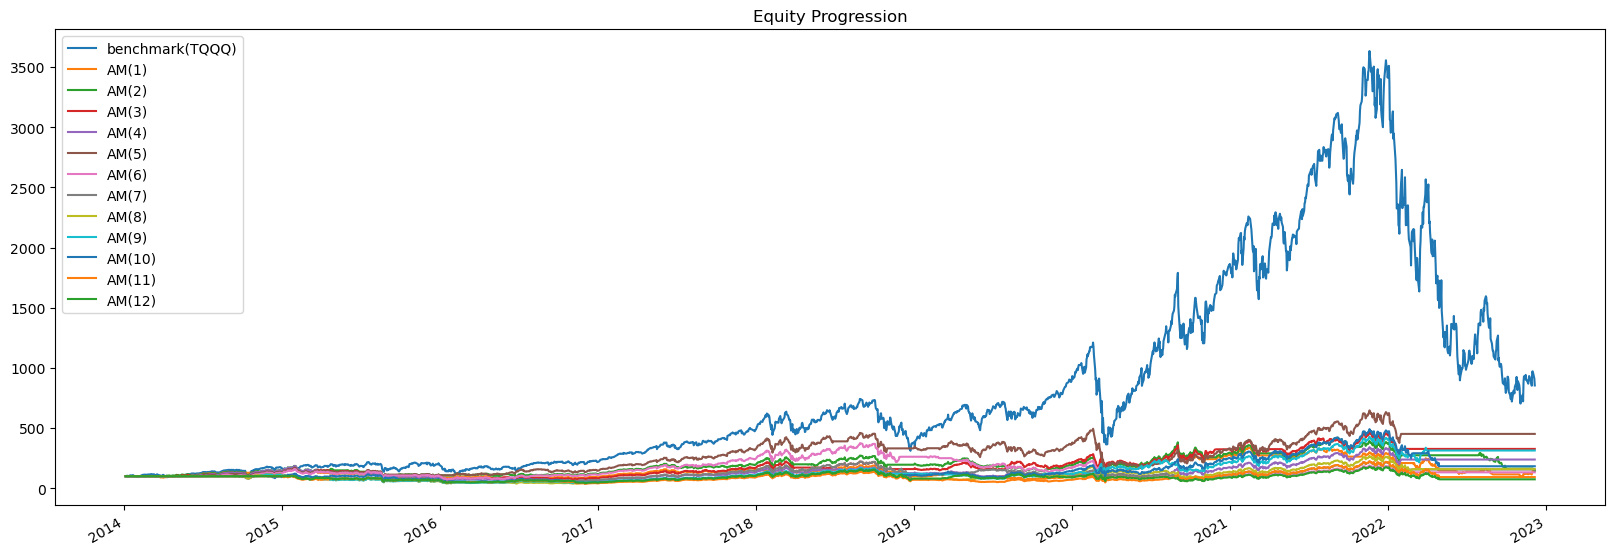

In [20]:
report.plot(figsize=(20,7))

In [21]:
print(report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TQQQ)    AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  -----------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05         2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06         2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%              0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         442.54%            4.85%       -6.27%      125.71%     56.83%      220.6

In [22]:
# 절대모멘텀 상위 2종목 (1~12개월 비교)
absolutemomentum = {}
for i in range(0, 12):
    start_day = assets.index.min() + pd.DateOffset(months=i+1) - pd.DateOffset(days=1)    
    absolutemomentum[i] = AbsoluteMomentum_BT(assets[tickers], 2, i+1, start_day, name='AM({})'.format(str(i+1)))
    
report = bt.run(benchmark, *absolutemomentum.values())

<AxesSubplot:title={'center':'Equity Progression'}>

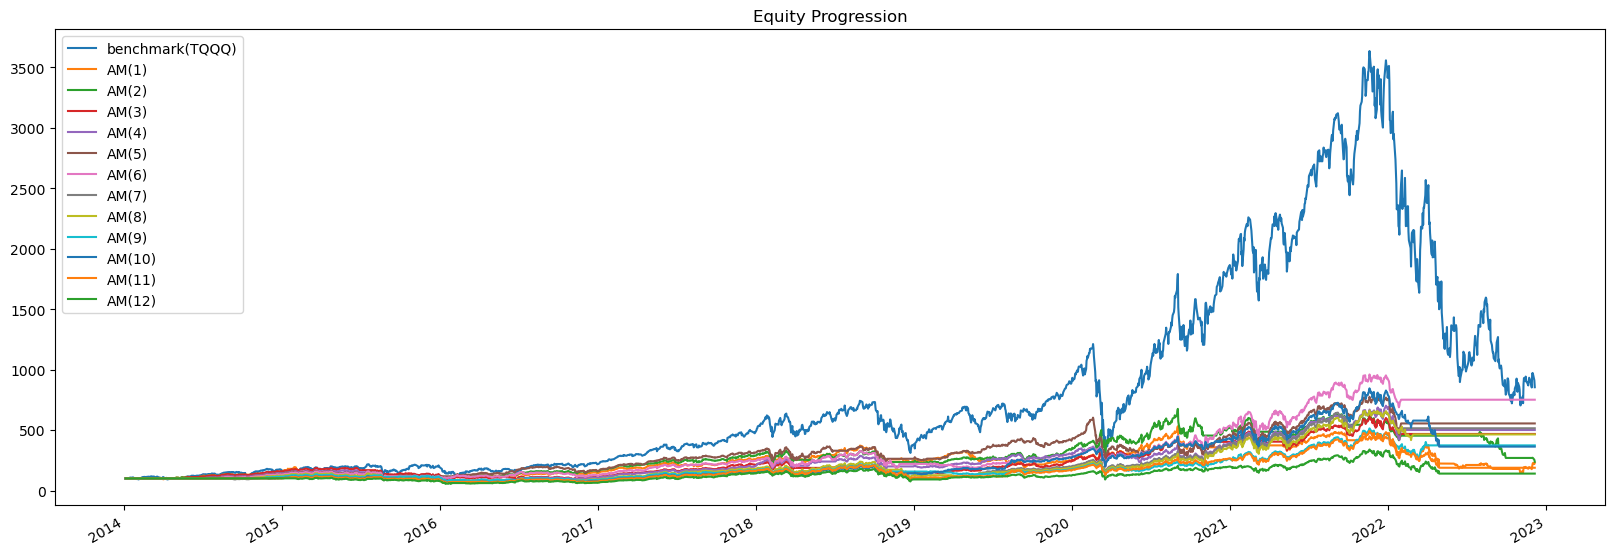

In [23]:
report.plot(figsize=(20,7))

In [24]:
print(report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TQQQ)    AM(1)       AM(2)       AM(3)       AM(4)       AM(5)       AM(6)       AM(7)       AM(8)       AM(9)       AM(10)      AM(11)      AM(12)
-------------------  -----------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05         2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06         2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%              0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         442.54%            42.51%      53.34%      193.64%     249.10%     303.4

In [28]:
# 듀얼모멘텀 상위 1종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    start_day = assets.index.min() + pd.DateOffset(months=i+1) - pd.DateOffset(days=1)
    dualmomentums[i] = DualMomentum_BT(assets, 1, i+1, start_day, name='ODM({})'.format(str(i+1)))

report = bt.run(benchmark, *dualmomentums.values())

<AxesSubplot:title={'center':'Equity Progression'}>

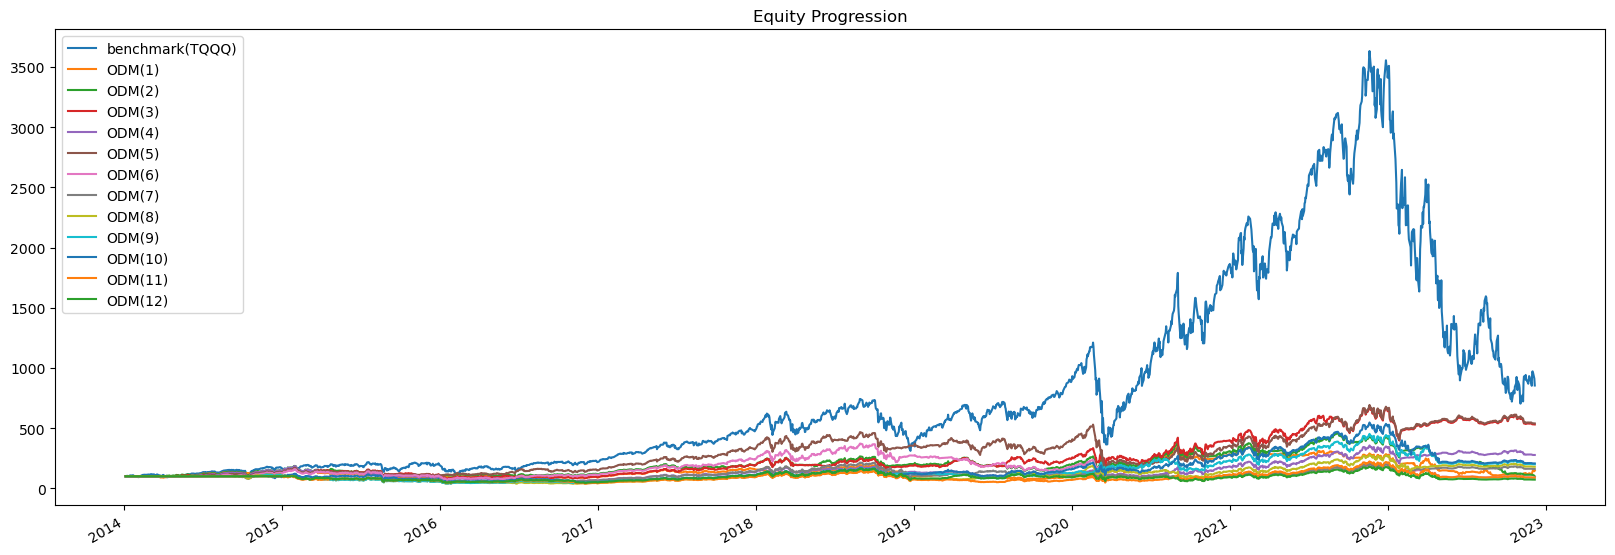

In [29]:
report.plot(figsize=(20,7))

In [30]:
print(report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TQQQ)    ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  -----------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05         2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06         2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%              0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         442.54%            6.39%       -35.85%     266.36%     82.18%      282.

In [31]:
# 듀얼모멘텀 상위 2종목 (1~12개월 비교)
dualmomentums = {}
for i in range(0, 12):
    start_day = assets.index.min() + pd.DateOffset(months=i+1) - pd.DateOffset(days=1)
    dualmomentums[i] = DualMomentum_BT(assets, 2, i+1, start_day, name='ODM({})'.format(str(i+1)))

report = bt.run(benchmark, *dualmomentums.values())

<AxesSubplot:title={'center':'Equity Progression'}>

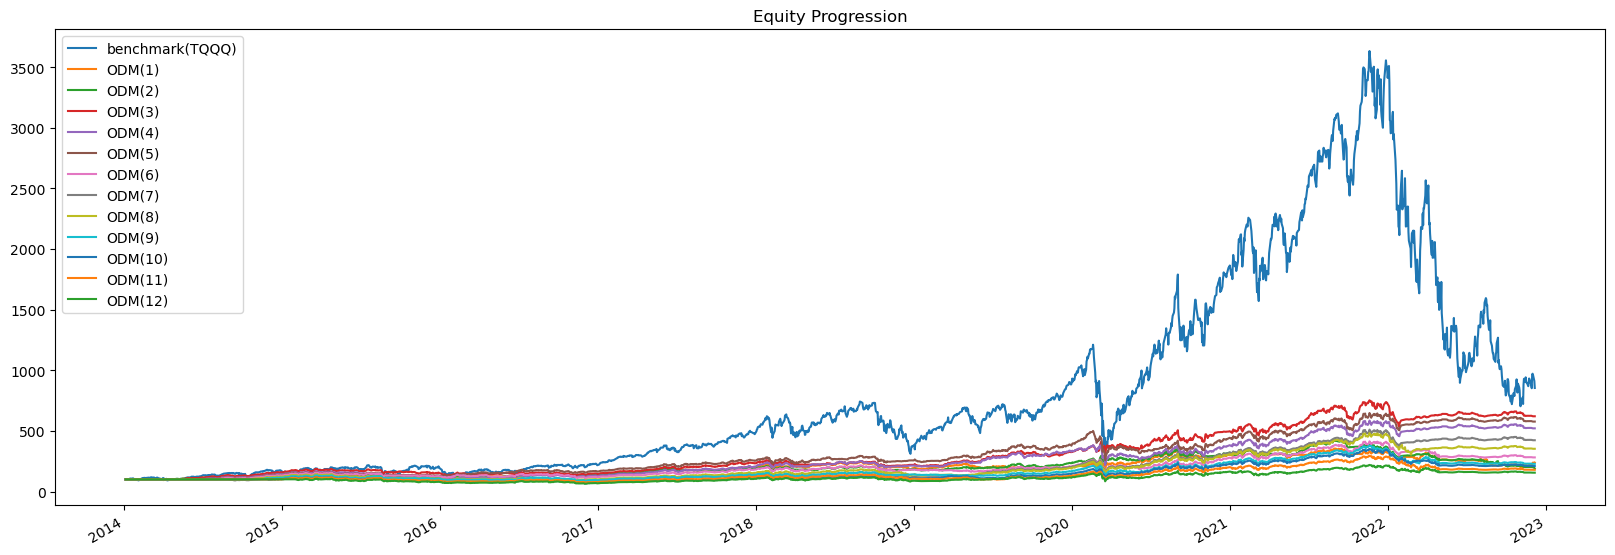

In [32]:
report.plot(figsize=(20,7))

In [33]:
print(report.prices[start_day:].calc_stats().display())

Stat                 benchmark(TQQQ)    ODM(1)      ODM(2)      ODM(3)      ODM(4)      ODM(5)      ODM(6)      ODM(7)      ODM(8)      ODM(9)      ODM(10)     ODM(11)     ODM(12)
-------------------  -----------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2015-01-05         2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05  2015-01-05
End                  2022-12-06         2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06  2022-12-06
Risk-free rate       0.00%              0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         442.54%            64.13%      28.96%      289.70%     263.62%     319.